In [1]:
%%bash
cat > steer_llm.py << 'EOF'
#!/usr/bin/env python3
"""
Enhanced Script for Steering LLM Behavior (e.g., Epistemic Stance, Stylistic Features)
using Activation Vector Manipulation in models like LLaMA-3-8B-Instruct.

Targeted for Research Publication - Incorporates learnings from iterative experiments.

Features:
- CLI with subcommands: compute-vector, steer, evaluate-perplexity
- Flexible text pair input (JSON) for concept vector computation.
  Example Concepts:
  - "Degree of Certainty":
    --positive_texts_json: high_certainty_texts.json
    --negative_texts_json: low_certainty_texts.json
  - "Sentence Complexity":
    --positive_texts_json: complex_sentence_texts.json (e.g., original from GEM/wiki_auto_asset_turk)
    --negative_texts_json: simple_sentence_texts.json (e.g., simplified from GEM/wiki_auto_asset_turk)

- Concept vector derived using a Linear Probe (Logistic Regression) on MLP activations.
- Options for token aggregation strategy (mean_all_tokens, last_token) for probe training.
- Optional normalization for the computed concept vector.
- Support for multi-layer MLP steering with specified strengths.
- Optional Activation Clipping during steering for fluency control.
- Perplexity evaluation (uses external model like GPT-2 for less bias).
- Save/load concept vectors (dictionary mapping layer_index to vector).
- Comprehensive logging and CLI arguments for reproducibility.
"""
import os
import sys
import argparse
import json
import logging
import torch
import numpy as np
from torch.nn.functional import normalize as torch_normalize
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    GenerationConfig,
    set_seed
)
from datasets import load_dataset
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from huggingface_hub import login

# ----- Logging Configuration -----
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(module)s:%(lineno)d %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S"
)
logger = logging.getLogger(__name__)

# Optional HF authentication
HF_TOKEN = os.environ.get('HF_TOKEN')
if HF_TOKEN:
    login(token=HF_TOKEN)

# Strip Jupyter args
orig_args = sys.argv[:]
clean_args = [orig_args[0]]
skip_next = False
for a in orig_args[1:]:
    if skip_next:
        skip_next = False
        continue
    if a == '-f':
        skip_next = True
        continue
    b = os.path.basename(a)
    if b.startswith('kernel-') and b.endswith('.json'):
        continue
    clean_args.append(a)
sys.argv = clean_args

# ----- Utility Functions -----

def load_model_and_tokenizer(model_name: str, device: str = 'cuda', dtype_str: str = 'bfloat16'):
    logger.info(f"Loading model {model_name} on {device} (dtype={dtype_str})")
    if dtype_str == 'bfloat16':
        dtype = torch.bfloat16
    elif dtype_str == 'float16':
        dtype = torch.float16
    else:
        dtype = torch.float32

    tokenizer = AutoTokenizer.from_pretrained(model_name, use_auth_token=HF_TOKEN)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token or tokenizer.pad_token_id
    tokenizer.padding_side = 'left'

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=dtype,
        device_map='auto',
        use_auth_token=HF_TOKEN
    )
    model.eval()
    return model, tokenizer

class ActivationExtractor:
    def __init__(self, model, mlp_layer_indices):
        self.model = model
        self.layer_indices = mlp_layer_indices
        self.handles = []
        self.activations = {idx: [] for idx in mlp_layer_indices}

    def _make_hook(self, idx):
        def hook(module, inp, outp):
            self.activations[idx].append(outp.detach().cpu())
        return hook

    def register(self):
        self.unregister()
        self.activations = {idx: [] for idx in self.layer_indices}
        for idx in self.layer_indices:
            actual = idx if idx >= 0 else len(self.model.model.layers) + idx
            module = self.model.model.layers[actual].mlp
            handle = module.register_forward_hook(self._make_hook(actual))
            self.handles.append(handle)
        logger.info(f"Registered hooks at MLP layers: {self.layer_indices}")

    def unregister(self):
        for h in self.handles:
            h.remove()
        self.handles = []

# ----- Core Functionality -----

def compute_concept_vector_with_probe(
    model, tokenizer,
    positive_texts, negative_texts,
    mlp_layer_indices, batch_size: int,
    aggregation_strategy: str, normalize_vector: bool,
    seed: int, device: str, max_length: int
):
    set_seed(seed)
    layers = [idx if idx >= 0 else len(model.model.layers) + idx for idx in mlp_layer_indices]
    extractor = ActivationExtractor(model, layers)
    extractor.register()

    def collect_activations(texts, label):
        all_acts = {idx: [] for idx in layers}
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            inputs = tokenizer(batch, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(device)
            extractor.register()
            with torch.no_grad(): model(**inputs)
            for idx in layers:
                feats = torch.cat(extractor.activations[idx], dim=0)
                if aggregation_strategy == 'mean_all_tokens':
                    feats = feats.mean(dim=1)
                else:
                    lengths = inputs.attention_mask.sum(dim=1)
                    feats = torch.stack([feats[k, lengths[k]-1] for k in range(feats.size(0))])
                all_acts[idx].append(feats)
        return all_acts

    pos_acts = collect_activations(positive_texts, 'pos')
    neg_acts = collect_activations(negative_texts, 'neg')
    extractor.unregister()

    concept_vectors = {}
    for idx in layers:
        X_pos = torch.cat(pos_acts[idx], dim=0).numpy()
        X_neg = torch.cat(neg_acts[idx], dim=0).numpy()
        y = np.array([1]*len(X_pos) + [0]*len(X_neg))
        X = np.vstack([X_pos, X_neg])
        scaler = StandardScaler(); X_scaled = scaler.fit_transform(X)
        probe = LogisticRegression(solver='liblinear', C=1.0, class_weight='balanced', random_state=seed)
        probe.fit(X_scaled, y)
        coef = probe.coef_[0]
        vec = torch_normalize(torch.tensor(coef, dtype=torch.float32).unsqueeze(0), dim=1).squeeze(0) if normalize_vector else torch.tensor(coef, dtype=torch.float32)
        concept_vectors[idx] = vec.to(device)
        logger.info(f"Computed concept vector for layer {idx}, norm={vec.norm():.3f}")
    return concept_vectors


def steer_generation_with_mlp_intervention(
    model, tokenizer, prompt: str,
    concept_vectors: dict, strengths: dict,
    max_new_tokens: int, temperature: float, do_sample: bool,
    clip_min: float, clip_max: float, device: str, seed: int
):
    set_seed(seed)
    handles = []
    for layer_str, strength in strengths.items():
        layer_idx = int(layer_str)
        actual = layer_idx if layer_idx >= 0 else len(model.model.layers) + layer_idx
        vec = concept_vectors.get(actual)
        if vec is None or strength == 0: continue
        def hook_fn(v, st):
            def fn(mod, inp, outp):
                out = outp + st * v.unsqueeze(0).unsqueeze(0)
                return torch.clamp(out, clip_min, clip_max) if clip_min is not None else out
            return fn
        module = model.model.layers[actual].mlp
        handles.append(module.register_forward_hook(hook_fn(vec, strength)))
        logger.info(f"Steering hook on layer {actual} strength={strength}")

    gen_cfg = GenerationConfig(max_new_tokens=max_new_tokens, do_sample=do_sample, temperature=temperature, pad_token_id=tokenizer.pad_token_id, eos_token_id=tokenizer.eos_token_id)
    inputs = tokenizer(prompt, return_tensors='pt', truncation=True, padding=True).to(device)
    with torch.no_grad(): outputs = model.generate(**inputs, generation_config=gen_cfg)
    for h in handles: h.remove()
    return tokenizer.decode(outputs[0], skip_special_tokens=True)


def evaluate_perplexity_external(texts, ppl_model_name: str, device: str, batch_size: int):
    from transformers import AutoModelForCausalLM, AutoTokenizer
    tok = AutoTokenizer.from_pretrained(ppl_model_name)
    mod = AutoModelForCausalLM.from_pretrained(ppl_model_name).to(device)
    mod.eval()
    if tok.pad_token is None: tok.pad_token = tok.eos_token
    total_nll, total_tokens = 0.0, 0
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = tok(batch, return_tensors='pt', padding=True, truncation=True).to(device)
        with torch.no_grad(): out = mod(enc.input_ids, labels=enc.input_ids)
        total_nll += out.loss.item() * enc.input_ids.numel()
        total_tokens += enc.input_ids.numel()
    ppl = torch.exp(torch.tensor(total_nll/total_tokens)).item() if total_tokens>0 else float('inf')
    logger.info(f"Perplexity: {ppl:.2f}")
    return ppl

# ----- CLI -----

def main():
    parser = argparse.ArgumentParser(description="LLM Concept Steering CLI")
    parser.add_argument('--model_name', type=str, default="meta-llama/Llama-3.1-8B-Instruct")
    parser.add_argument('--dtype', type=str, default='bfloat16', choices=['bfloat16','float16','float32'])
    parser.add_argument('--seed', type=int, default=42)
    sub = parser.add_subparsers(dest='cmd', required=True)

    cvp = sub.add_parser('compute-vector')
    cvp.add_argument('--positive_texts_json', required=True)
    cvp.add_argument('--negative_texts_json', required=True)
    cvp.add_argument('--mlp_layer_indices', nargs='+', type=int, default=[-1])
    cvp.add_argument('--batch_size', type=int, default=8)
    cvp.add_argument('--aggregation_strategy', choices=['mean_all_tokens','last_token'], default='mean_all_tokens')
    cvp.add_argument('--normalize_vector', action='store_true')
    cvp.add_argument('--max_length', type=int, default=192)
    cvp.add_argument('--output_vector_file', required=True)

    stp = sub.add_parser('steer')
    stp.add_argument('--prompt', required=True)
    stp.add_argument('--concept_vector_file', required=True)
    stp.add_argument('--strengths_json', required=True)
    stp.add_argument('--max_new_tokens', type=int, default=60)
    stp.add_argument('--temperature', type=float, default=0.7)
    stp.add_argument('--do_sample', action='store_true')
    stp.add_argument('--clip_min', type=float)
    stp.add_argument('--clip_max', type=float)

    evp = sub.add_parser('evaluate-perplexity')
    evp.add_argument('--texts_json', required=True)
    evp.add_argument('--ppl_model_name', default='gpt2')
    evp.add_argument('--batch_size', type=int, default=4)

    args = parser.parse_args()
    set_seed(args.seed)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    if args.cmd=='compute-vector':
        model, tok = load_model_and_tokenizer(args.model_name, device=device, dtype_str=args.dtype)
        pos = json.load(open(args.positive_texts_json)); neg = json.load(open(args.negative_texts_json))
        cvs = compute_concept_vector_with_probe(
            model, tok, pos, neg, args.mlp_layer_indices, args.batch_size,
            args.aggregation_strategy, args.normalize_vector, args.seed,
            device, args.max_length
        )
        torch.save(cvs, args.output_vector_file)
    elif args.cmd=='steer':
        model, tok = load_model_and_tokenizer(args.model_name, device=device, dtype_str=args.dtype)
        cvs = torch.load(args.concept_vector_file)
        strengths = json.load(open(args.strengths_json))
        out = steer_generation_with_mlp_intervention(
            model, tok, args.prompt, cvs, strengths,
            args.max_new_tokens, args.temperature, args.do_sample,
            args.clip_min, args.clip_max, device, args.seed
        )
        print(out)
    else:
        texts = json.load(open(args.texts_json)); evaluate_perplexity_external(texts, args.ppl_model_name, device, args.batch_size)

if __name__=='__main__':
    main()
EOF

In [2]:
!pip install transformers accelerate bitsandbytes torch scikit-learn matplotlib seaborn umap-learn huggingface_hub -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 44.1 MB/s eta 0:00:00


In [3]:
!pip install -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 13.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.


In [4]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline as hf_pipeline
from datasets import load_dataset, get_dataset_config_names
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from huggingface_hub import login, HfFolder
import os
import shutil

# --- User Configuration ---
MODEL_NAME = "meta-llama/Meta-Llama-3-8B-Instruct"
use_quantization = True

# --- Hugging Face Token ---
print("Attempting Hugging Face login...")
try:
    if HfFolder.get_token() is None:
        print("Hugging Face token not found in cache. Please log in when prompted.")
        login()
        print("Login successful (or token was already cached and valid).")
    else:
        print(f"Hugging Face token found in cache: {HfFolder.get_token()[:10]}... (masked)")
except Exception as e:
    print(f"Error during Hugging Face login attempt: {e}"); raise

Attempting Hugging Face login...
Hugging Face token found in cache: hf_KTFplid... (masked)


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == 'cpu': print("WARNING: Running on CPU will be very slow.")

# --- Load Tokenizer and Model ---
print(f"Loading tokenizer for '{MODEL_NAME}'...");
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME);
print("Tokenizer loaded.")

print(f"Loading model '{MODEL_NAME}'...")
if use_quantization:
    bnb_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_use_double_quant=True, bnb_4bit_compute_dtype=torch.bfloat16)
    model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, quantization_config=bnb_config, device_map="auto", torch_dtype=torch.bfloat16)
    print(f"Model '{MODEL_NAME}' loaded with 4-bit quantization.")
else:
    model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, device_map="auto", torch_dtype=torch.bfloat16)
    print(f"Model '{MODEL_NAME}' loaded without quantization.")

if tokenizer.pad_token is None:
    if tokenizer.eos_token is not None:
        tokenizer.pad_token = tokenizer.eos_token
        if hasattr(model, 'config') and model.config.pad_token_id is None: model.config.pad_token_id = tokenizer.pad_token_id
        print(f"Set pad_token to eos_token: {tokenizer.pad_token} (ID: {tokenizer.pad_token_id})")
    else:
        tokenizer.add_special_tokens({'pad_token': '[PAD]'}); model.resize_token_embeddings(len(tokenizer))
        if hasattr(model, 'config'): model.config.pad_token_id = tokenizer.pad_token_id
        print(f"Added new pad_token: {tokenizer.pad_token} (ID: {tokenizer.pad_token_id})")
print("Cell 1 Setup Complete.")

Using device: cuda
Loading tokenizer for 'meta-llama/Meta-Llama-3-8B-Instruct'...


tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Tokenizer loaded.
Loading model 'meta-llama/Meta-Llama-3-8B-Instruct'...


config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

Model 'meta-llama/Meta-Llama-3-8B-Instruct' loaded with 4-bit quantization.
Set pad_token to eos_token: <|eot_id|> (ID: 128009)
Cell 1 Setup Complete.


In [6]:
CONCEPT_NAME_I8 = "sentence_complexity_wiki_auto"
N_SAMPLES_FOR_COMPLEXITY_VC = 100
WIKIAUTO_DATASET_PATH = "GEM/wiki_auto_asset_turk"
# Order of preference for splits, as these are direct split names for this dataset.
SPLITS_TO_TRY = ["test_turk", "test_asset"]

print(f"Attempting to load '{CONCEPT_NAME_I8}' data from Hugging Face dataset: '{WIKIAUTO_DATASET_PATH}'")

simple_texts_for_vc_i8 = []
complex_texts_for_vc_i8 = []
data_loaded_successfully_i8 = False
final_split_used = None
dataset_to_process = None

try:
    for split_name_attempt in SPLITS_TO_TRY:
        try:
            print(f"\nAttempting to directly load split: '{split_name_attempt}' from '{WIKIAUTO_DATASET_PATH}'...")
            # Load the specific split directly using the split= argument
            dataset_to_process = load_dataset(WIKIAUTO_DATASET_PATH, split=split_name_attempt, trust_remote_code=True)
            final_split_used = split_name_attempt
            print(f"Successfully loaded data for split: '{final_split_used}'.")
            break # Stop if a split is successfully loaded
        except Exception as e_load:
            print(f"  Could not load split '{split_name_attempt}': {e_load}")
            dataset_to_process = None
            final_split_used = None

    if dataset_to_process is None:
        # This means neither "test_turk" nor "test_asset" could be loaded directly as a split.
        # This would be unusual if the dataset path is correct and has these splits.
        # As a final fallback, try loading the whole thing and then selecting.
        print(f"\nDirect split loading failed. Trying to load whole DatasetDict for '{WIKIAUTO_DATASET_PATH}' and then select split...")
        full_dataset_dict = load_dataset(WIKIAUTO_DATASET_PATH, trust_remote_code=True)
        available_splits_in_dict = list(full_dataset_dict.keys())
        print(f"Full DatasetDict loaded. Available splits/keys: {available_splits_in_dict}")
        for split_key_attempt in SPLITS_TO_TRY: # Try again with keys from dict
            if split_key_attempt in full_dataset_dict:
                dataset_to_process = full_dataset_dict[split_key_attempt]
                final_split_used = split_key_attempt
                print(f"Successfully selected data from DatasetDict for split: '{final_split_used}'.")
                break
        if dataset_to_process is None:
             raise ValueError(f"Failed to load any of the target splits ({SPLITS_TO_TRY}) even after loading full DatasetDict from '{WIKIAUTO_DATASET_PATH}'.")


    print(f"\nUsing data from split: '{final_split_used}'. Number of available entries: {len(dataset_to_process)}")

    from sklearn.utils import shuffle
    # dataset_to_process is already a datasets.Dataset object
    shuffled_dataset = dataset_to_process.shuffle(seed=42)

    num_available_entries = len(shuffled_dataset)
    n_entries_to_select = min(N_SAMPLES_FOR_COMPLEXITY_VC, num_available_entries)

    if n_entries_to_select == 0:
        raise ValueError(f"No data available after shuffling or sample size is 0 for split '{final_split_used}'.")

    print(f"Attempting to select up to {n_entries_to_select} valid entries from '{final_split_used}' split...")

    count = 0
    processed_count = 0

    for i in range(n_entries_to_select): # Iterate only up to n_entries_to_select from the shuffled data
        entry = shuffled_dataset[i]
        processed_count += 1

        # Field names for GEM/wiki_auto_asset_turk: 'source' for original, 'references' for simplified list
        original_sentence_text = entry.get('source')
        simplified_sentences_list = entry.get('references')

        is_original_valid = False; is_simplified_valid = False
        original_text_to_use = None; simplified_text_to_use = None

        if isinstance(original_sentence_text, str) and original_sentence_text.strip():
            is_original_valid = True
            original_text_to_use = original_sentence_text.strip()

        if isinstance(simplified_sentences_list, list) and len(simplified_sentences_list) > 0:
            if isinstance(simplified_sentences_list[0], str) and simplified_sentences_list[0].strip():
                is_simplified_valid = True
                simplified_text_to_use = simplified_sentences_list[0].strip()

        if processed_count <= 10:
            print(f"\n--- Debugging Processed Entry {i} from split '{final_split_used}' ---")
            print(f"  Raw source field (original/complex): '{entry.get('source')}'")
            print(f"  Raw references field (simplified): {entry.get('references')}")
            print(f"  is_original_valid: {is_original_valid}, is_simplified_valid: {is_simplified_valid}")

        if is_original_valid and is_simplified_valid:
            complex_texts_for_vc_i8.append(original_text_to_use)
            simple_texts_for_vc_i8.append(simplified_text_to_use)
            count += 1

    print(f"\nProcessed {processed_count} entries from '{final_split_used}'.")

    if not complex_texts_for_vc_i8 or not simple_texts_for_vc_i8 or count == 0 :
        raise ValueError(f"No valid complex/simple text pairs were extracted from {processed_count} processed samples of '{final_split_used}' after filtering. Check debug prints and actual dataset field names/structure for this split.")

    print(f"\nSuccessfully loaded and sampled data from {WIKIAUTO_DATASET_PATH} (using split: '{final_split_used}'). Obtained {count} pairs.")
    data_loaded_successfully_i8 = True

except Exception as e:
    print(f"\nERROR loading or processing WikiAuto dataset ('{WIKIAUTO_DATASET_PATH}'): {e}")
    print(f"Please double-check the dataset details and available splits/fields on Hugging Face Hub: https://huggingface.co/datasets/{WIKIAUTO_DATASET_PATH}")
    print("\nFalling back to manual small curated dataset for sentence complexity.")
    simple_texts_for_vc_i8 = [
        "The cat sat on the mat.", "Birds fly in the blue sky.", "The sun is very bright today.",
        "She likes to read books.", "He plays games after school."
    ]
    complex_texts_for_vc_i8 = [
        "The feline, a creature of habit and grace, positioned itself comfortably upon the woven floor covering.",
        "Avian species, endowed with the remarkable ability of flight, navigate the cerulean expanse of the atmosphere.",
        "Today, the solar celestial body emits an exceptionally luminous and brilliant radiance.",
        "She derives considerable intellectual stimulation and pleasure from the perusal of literary works.",
        "Subsequent to the completion of his academic obligations, he engages in recreational digital pastimes."
    ]
    print(f"Using fallback manual dataset: {len(simple_texts_for_vc_i8)} simple / {len(complex_texts_for_vc_i8)} complex examples.")

print(f"\nFinal number of simple examples for v_C definition: {len(simple_texts_for_vc_i8)}")
print(f"Final number of complex examples for v_C definition: {len(complex_texts_for_vc_i8)}")

Attempting to load 'sentence_complexity_wiki_auto' data from Hugging Face dataset: 'GEM/wiki_auto_asset_turk'

Attempting to directly load split: 'test_turk' from 'GEM/wiki_auto_asset_turk'...


README.md:   0%|          | 0.00/34.8k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/89.5M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

test_asset-00000-of-00001.parquet:   0%|          | 0.00/204k [00:00<?, ?B/s]

test_turk-00000-of-00001.parquet:   0%|          | 0.00/174k [00:00<?, ?B/s]

test_contract-00000-of-00001.parquet:   0%|          | 0.00/194k [00:00<?, ?B/s]

test_wiki-00000-of-00001.parquet:   0%|          | 0.00/180k [00:00<?, ?B/s]

(…)enge_train_sample-00000-of-00001.parquet:   0%|          | 0.00/123k [00:00<?, ?B/s]

(…)validation_sample-00000-of-00001.parquet:   0%|          | 0.00/90.1k [00:00<?, ?B/s]

(…)t_backtranslation-00000-of-00001.parquet:   0%|          | 0.00/186k [00:00<?, ?B/s]

(…)_test_asset_bfp02-00000-of-00001.parquet:   0%|          | 0.00/187k [00:00<?, ?B/s]

(…)_test_asset_bfp05-00000-of-00001.parquet:   0%|          | 0.00/188k [00:00<?, ?B/s]

(…)test_asset_nopunc-00000-of-00001.parquet:   0%|          | 0.00/186k [00:00<?, ?B/s]

(…)k_backtranslation-00000-of-00001.parquet:   0%|          | 0.00/174k [00:00<?, ?B/s]

(…)e_test_turk_bfp02-00000-of-00001.parquet:   0%|          | 0.00/176k [00:00<?, ?B/s]

(…)e_test_turk_bfp05-00000-of-00001.parquet:   0%|          | 0.00/177k [00:00<?, ?B/s]

(…)_test_turk_nopunc-00000-of-00001.parquet:   0%|          | 0.00/174k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/483801 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating test_asset split:   0%|          | 0/359 [00:00<?, ? examples/s]

Generating test_turk split:   0%|          | 0/359 [00:00<?, ? examples/s]

Generating test_contract split:   0%|          | 0/659 [00:00<?, ? examples/s]

Generating test_wiki split:   0%|          | 0/720 [00:00<?, ? examples/s]

Generating challenge_train_sample split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating challenge_validation_sample split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating challenge_test_asset_backtranslation split:   0%|          | 0/359 [00:00<?, ? examples/s]

Generating challenge_test_asset_bfp02 split:   0%|          | 0/359 [00:00<?, ? examples/s]

Generating challenge_test_asset_bfp05 split:   0%|          | 0/359 [00:00<?, ? examples/s]

Generating challenge_test_asset_nopunc split:   0%|          | 0/359 [00:00<?, ? examples/s]

Generating challenge_test_turk_backtranslation split:   0%|          | 0/359 [00:00<?, ? examples/s]

Generating challenge_test_turk_bfp02 split:   0%|          | 0/359 [00:00<?, ? examples/s]

Generating challenge_test_turk_bfp05 split:   0%|          | 0/359 [00:00<?, ? examples/s]

Generating challenge_test_turk_nopunc split:   0%|          | 0/359 [00:00<?, ? examples/s]

Successfully loaded data for split: 'test_turk'.

Using data from split: 'test_turk'. Number of available entries: 359
Attempting to select up to 100 valid entries from 'test_turk' split...

--- Debugging Processed Entry 0 from split 'test_turk' ---
  Raw source field (original/complex): 'The Montreal Canadiens are a skilled ice hockey team from Montreal, Quebec, Canada.'
  Raw references field (simplified): ['The Montreal Canadiens are a professional ice hockey team based in Montreal, Quebec, Canada.', 'The Montreal Canadiens are a professional ice hockey team based in Montreal . Montreal was Quebec, Canada.', 'The Montreal Canadians is a professional ice hockey team based in Montreal, Quebec, Canada.', 'The Montreal Canadiens are a professional ice hockey team from Montreal.', 'The Montreal Canadiens are one of the best, perfect, well qualified, hard working ice hockey team based in Montreal, Quebec, Canada.', 'The Montreal Canadiens are a ice hockey team based in Montreal Quebec.', 

Targeting module for COMPLEXITY v_C ACTIVATION EXTRACTION: LlamaDecoderLayer (Layer -1)
Registered complexity v_C extraction hook on L_minus_1_output_for_complexity_vc.
Using token aggregation strategy: mean for complexity v_C.
  Processing 100 texts for complexity v_C in 7 batches of size 16 (agg: mean, max_len: 128)...
Complex text activations extracted. Shape: torch.Size([100, 4096])
  Processing 100 texts for complexity v_C in 7 batches of size 16 (agg: mean, max_len: 128)...
Simple text activations extracted. Shape: torch.Size([100, 4096])

--- Iteration 8: Training Linear Probe for Sentence Complexity Concept Vector ---
Linear probe for SENTENCE COMPLEXITY trained. Accuracy: 99.50%
Concept vector (v_C) for SENTENCE COMPLEXITY from PROBE calculated. Shape: torch.Size([4096])
Complexity v_C Activation extraction hook removed.

Running PCA on 200 complexity activations...


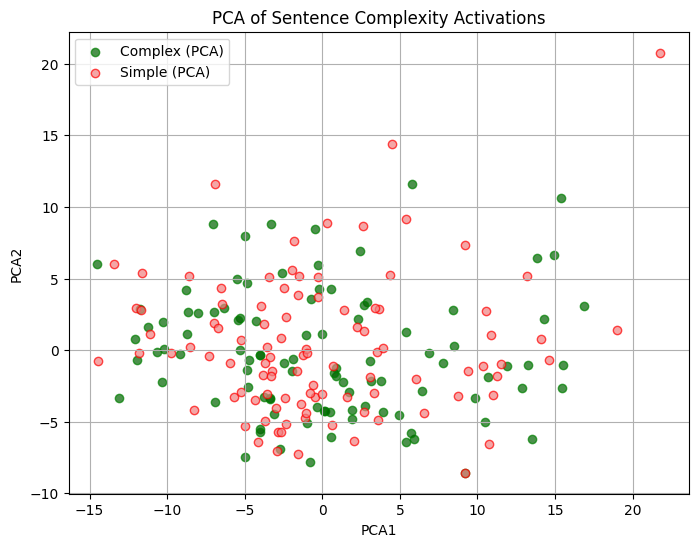

In [7]:
activations_storage_i8 = {}
def get_activation_hook_i8(layer_name_in_storage):
    def hook(model_module, M_input, M_output):
        activations_storage_i8[layer_name_in_storage] = (M_output[0] if isinstance(M_output, tuple) else M_output).detach()
    return hook

target_module_for_vc_extraction_i8 = None
hook_handle_vc_extraction_i8 = None
vc_extraction_hook_storage_name_i8 = "L_minus_1_output_for_complexity_vc"

try:
    target_module_for_vc_extraction_i8 = model.model.layers[-1]
    print(f"Targeting module for COMPLEXITY v_C ACTIVATION EXTRACTION: {type(target_module_for_vc_extraction_i8).__name__} (Layer -1)")
except Exception as e:
    print(f"Error accessing model.model.layers[-1] for complexity v_C extraction: {e}")

if target_module_for_vc_extraction_i8:
    if 'hook_handle_vc_extraction_i8' in globals() and hook_handle_vc_extraction_i8 is not None:
        try: hook_handle_vc_extraction_i8.remove(); print("Removed pre-existing complexity v_C extraction hook.")
        except: pass
    hook_handle_vc_extraction_i8 = target_module_for_vc_extraction_i8.register_forward_hook(get_activation_hook_i8(vc_extraction_hook_storage_name_i8))
    print(f"Registered complexity v_C extraction hook on {vc_extraction_hook_storage_name_i8}.")
else:
    print("Skipping complexity v_C extraction hook registration as target module not found.")

def get_activations_for_texts_batch_i8(texts_batch, storage_name, agg_token_strategy='mean', batch_size=16, max_len=128): # Using batch_size for potentially many examples
    all_relevant_activations = []
    num_batches = (len(texts_batch) + batch_size - 1) // batch_size
    print(f"  Processing {len(texts_batch)} texts for complexity v_C in {num_batches} batches of size {batch_size} (agg: {agg_token_strategy}, max_len: {max_len})...")

    for i in range(num_batches):
        start_idx = i * batch_size; end_idx = min((i + 1) * batch_size, len(texts_batch))
        current_batch_texts = texts_batch[start_idx:end_idx]
        if not current_batch_texts: continue

        inputs = tokenizer(current_batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=max_len).to(device)
        if storage_name in activations_storage_i8: del activations_storage_i8[storage_name]
        with torch.no_grad(): _ = model(**inputs)
        batch_activations = activations_storage_i8.get(storage_name)
        if batch_activations is None: raise ValueError(f"Activations not found: '{storage_name}' for batch {i+1}. Hook issue?")

        batch_activations_cpu = batch_activations.cpu()

        if agg_token_strategy == 'mean':
            all_relevant_activations.append(batch_activations_cpu.mean(dim=1))
        elif agg_token_strategy == -1:
            seq_lens = inputs.attention_mask.sum(dim=1)
            for j in range(batch_activations_cpu.shape[0]):
                all_relevant_activations.append(batch_activations_cpu[j, max(0, seq_lens[j].item()-1), :])
        else:
            all_relevant_activations.append(batch_activations_cpu[:, agg_token_strategy, :])

    if not all_relevant_activations:
        hidden_size = model.config.hidden_size
        return torch.empty((0, hidden_size), dtype=torch.float32)

    if agg_token_strategy == -1 and all_relevant_activations and isinstance(all_relevant_activations[0], torch.Tensor) and all_relevant_activations[0].ndim == 1:
        return torch.stack(all_relevant_activations)
    elif all_relevant_activations:
        return torch.cat(all_relevant_activations, dim=0)
    else:
        hidden_size = model.config.hidden_size
        return torch.empty((0, hidden_size), dtype=torch.float32)

concept_vector_complexity = None
simple_activations_i8, complex_activations_i8 = None, None

if hook_handle_vc_extraction_i8 and target_module_for_vc_extraction_i8:
    complexity_token_aggregation_strategy = 'mean' # Mean pooling for sentence structure
    print(f"Using token aggregation strategy: {complexity_token_aggregation_strategy} for complexity v_C.")
    try:
        if not simple_texts_for_vc_i8 or not complex_texts_for_vc_i8: # Check lists from Cell 2
            raise ValueError("Simple or complex text lists for complexity v_C are empty. Check Cell 2 data loading.")

        # "Complex" texts will be treated as the "positive" class for the probe (label 1)
        complex_activations_i8 = get_activations_for_texts_batch_i8(complex_texts_for_vc_i8, vc_extraction_hook_storage_name_i8, complexity_token_aggregation_strategy)
        print(f"Complex text activations extracted. Shape: {complex_activations_i8.shape if complex_activations_i8 is not None else 'None'}")

        # "Simple" texts will be treated as the "negative" class for the probe (label 0)
        simple_activations_i8 = get_activations_for_texts_batch_i8(simple_texts_for_vc_i8, vc_extraction_hook_storage_name_i8, complexity_token_aggregation_strategy)
        print(f"Simple text activations extracted. Shape: {simple_activations_i8.shape if simple_activations_i8 is not None else 'None'}")

        if complex_activations_i8 is not None and simple_activations_i8 is not None and \
           complex_activations_i8.numel() > 0 and simple_activations_i8.numel() > 0:
            print("\n--- Iteration 8: Training Linear Probe for Sentence Complexity Concept Vector ---")
            from sklearn.linear_model import LogisticRegression
            from sklearn.preprocessing import StandardScaler

            all_acts_for_complexity_probe_torch = torch.cat([complex_activations_i8, simple_activations_i8], dim=0)
            all_acts_for_complexity_probe_numpy = all_acts_for_complexity_probe_torch.to(torch.float32).numpy()

            complexity_probe_labels = np.array([1]*len(complex_activations_i8) + [0]*len(simple_activations_i8)) # Complex=1, Simple=0

            complexity_scaler = StandardScaler(); all_complexity_acts_scaled = complexity_scaler.fit_transform(all_acts_for_complexity_probe_numpy)

            complexity_probe_classifier = LogisticRegression(solver='liblinear', C=0.1, class_weight='balanced', random_state=42)
            complexity_probe_classifier.fit(all_complexity_acts_scaled, complexity_probe_labels)
            accuracy = complexity_probe_classifier.score(all_complexity_acts_scaled, complexity_probe_labels)
            print(f"Linear probe for SENTENCE COMPLEXITY trained. Accuracy: {accuracy*100:.2f}%")

            complexity_probe_weights = complexity_probe_classifier.coef_[0]
            concept_vector_complexity = torch.tensor(complexity_probe_weights, dtype=torch.bfloat16).to(device)
            print(f"Concept vector (v_C) for SENTENCE COMPLEXITY from PROBE calculated. Shape: {concept_vector_complexity.shape}")
        else:
            print("Not enough activations from simple/complex data to train probe. Skipping v_C calculation.")
            concept_vector_complexity = None

    except Exception as e:
        print(f"Error during complexity v_C activation extraction or probe training: {e}")
        concept_vector_complexity = None
    finally:
        if hook_handle_vc_extraction_i8: hook_handle_vc_extraction_i8.remove(); print("Complexity v_C Activation extraction hook removed.")

    # --- Optional Visualizations of Activations used for Complexity Probe ---
    if complex_activations_i8 is not None and simple_activations_i8 is not None and \
       complex_activations_i8.numel() > 0 and simple_activations_i8.numel() > 0:
        all_complexity_extracted_activations_float32 = torch.cat([complex_activations_i8, simple_activations_i8], dim=0).to(torch.float32)
        all_complexity_extracted_activations_numpy = all_complexity_extracted_activations_float32.numpy()
        n_complex_i8 = len(complex_activations_i8)
        if all_complexity_extracted_activations_numpy.shape[0] > 1:
            print(f"\nRunning PCA on {all_complexity_extracted_activations_numpy.shape[0]} complexity activations...")
            pca_complexity = PCA(n_components=2); projected_pca_complexity = pca_complexity.fit_transform(all_complexity_extracted_activations_numpy)
            plt.figure(figsize=(8,6))
            plt.scatter(projected_pca_complexity[:n_complex_i8,0], projected_pca_complexity[:n_complex_i8,1],label="Complex (PCA)",c="darkgreen",edgecolors='green', alpha=0.7)
            plt.scatter(projected_pca_complexity[n_complex_i8:,0], projected_pca_complexity[n_complex_i8:,1],label="Simple (PCA)",c="lightcoral",edgecolors='red', alpha=0.7)
            plt.xlabel("PCA1");plt.ylabel("PCA2"); plt.title("PCA of Sentence Complexity Activations"); plt.legend(); plt.grid(True); plt.show()
else:
    print("Initial hook setup for complexity v_C extraction failed.")

In [8]:
final_min_clip_i8 = -25.0
final_max_clip_i8 = 25.0
print(f"Clipping range to be used for Iteration 8 'more complex' steering: [{final_min_clip_i8:.4f}, {final_max_clip_i8:.4f}]")

Clipping range to be used for Iteration 8 'more complex' steering: [-25.0000, 25.0000]


In [9]:
test_prompts_base_i8 = [
    "The weather forecast predicts",
    "Artificial intelligence is a field that",
    "To bake a cake, one must first",
    "The history of ancient Rome shows",
    "Environmental conservation efforts aim to"
]

ppl_model_i8, ppl_tokenizer_i8 = None, None
try:
    ppl_model_name_i8 = "gpt2"; print(f"Loading PPL model: {ppl_model_name_i8}...")
    ppl_tokenizer_i8 = AutoTokenizer.from_pretrained(ppl_model_name_i8)
    ppl_model_i8 = AutoModelForCausalLM.from_pretrained(ppl_model_name_i8).to(device)
    if ppl_tokenizer_i8.pad_token is None: ppl_tokenizer_i8.pad_token = ppl_tokenizer_i8.eos_token
    print(f"PPL model '{ppl_model_name_i8}' loaded.")
except Exception as e: print(f"Error loading PPL model: {e}")

def calculate_perplexity_i8(texts_list):
    if not texts_list or ppl_model_i8 is None: return float('inf')
    total_nll, total_tokens, valid_texts_count = 0, 0, 0
    for text_item in texts_list:
        if not isinstance(text_item, str) or not text_item.strip(): continue
        ppl_model_max_len = ppl_tokenizer_i8.model_max_length if hasattr(ppl_tokenizer_i8, 'model_max_length') and ppl_tokenizer_i8.model_max_length < 100000 else 1024
        encodings = ppl_tokenizer_i8(text_item,return_tensors="pt",padding=True,truncation=True,max_length=ppl_model_max_len).to(device)
        if encodings.input_ids.numel() == 0: continue
        valid_texts_count +=1
        with torch.no_grad(): outputs = ppl_model_i8(encodings.input_ids, labels=encodings.input_ids)
        total_nll += outputs.loss.item() * encodings.input_ids.size(1); total_tokens += encodings.input_ids.size(1)
    if total_tokens == 0: return float('inf')
    return torch.exp(torch.tensor(total_nll / total_tokens)).item()

print("Perplexity evaluation function and test_prompts_base defined for Iteration 8 (Sentence Complexity).")

Loading PPL model: gpt2...


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

PPL model 'gpt2' loaded.
Perplexity evaluation function and test_prompts_base defined for Iteration 8 (Sentence Complexity).


In [10]:
if 'concept_vector_complexity' not in globals() or concept_vector_complexity is None:
    print("ERROR: `concept_vector_complexity` is not defined from Cell 3. Cannot run Iteration 8.")
elif 'final_min_clip_i8' not in globals() or 'final_max_clip_i8' not in globals():
    print("ERROR: `final_min_clip_i8` or `final_max_clip_i8` not defined from Cell 3.5.")
else:
    print(f"Proceeding with Iteration 8 using SENTENCE COMPLEXITY $v_C$. Shape: {concept_vector_complexity.shape}.")
    print(f"Using Clipping range for 'more complex' steering: [{final_min_clip_i8:.4f}, {final_max_clip_i8:.4f}]")

    # --- Iteration 8 (Sentence Complexity) Configuration ---
    champion_actual_layer_index_i8 = -1
    try:
        num_model_layers_i8 = len(model.model.layers)
        champion_layer_idx_from_end_i8 = -3
        champion_actual_layer_index_i8 = num_model_layers_i8 + champion_layer_idx_from_end_i8
        if not (0 <= champion_actual_layer_index_i8 < num_model_layers_i8):
            raise ValueError(f"Champion steering layer index {champion_actual_layer_index_i8} out of bounds.")
        champion_steering_module_i8 = model.model.layers[champion_actual_layer_index_i8]
        if not hasattr(champion_steering_module_i8, 'layer_idx'): # Add layer_idx if not present
            champion_steering_module_i8.layer_idx = champion_actual_layer_index_i8
        print(f"Champion STEERING module for Iteration 8: FULL Decoder Layer {champion_actual_layer_index_i8}")
    except Exception as e:
        print(f"Error setting champion_steering_module for Iteration 8: {e}."); champion_steering_module_i8 = None

    alphas_to_test_complexity_i8 = [0.75, 1.5, -0.75, -1.5]
    max_new_gen_tokens_i8 = 60
    tokenizer_input_max_len_i8 = 512
    iteration_results_i8 = {}

    # --- Steering Hook Functions (with and without clipping) ---
    def complexity_steering_hook_fn_clip_on(concept_vec, alpha, clip_min, clip_max, steer_idx=-1):
        def hook(module, M_input, M_output):
            orig_out = M_output[0] if isinstance(M_output, tuple) else M_output; modified_out = orig_out.clone()
            cv_device = concept_vec.to(modified_out.device, dtype=modified_out.dtype)
            if steer_idx == -1: modified_out[:, -1:, :] += (alpha * cv_device.unsqueeze(0))
            modified_out = torch.clamp(modified_out, clip_min, clip_max)
            return (modified_out,) + M_output[1:] if isinstance(M_output, tuple) else modified_out
        return hook

    def complexity_steering_hook_fn_clip_off(concept_vec, alpha, steer_idx=-1):
        def hook(module, M_input, M_output):
            orig_out = M_output[0] if isinstance(M_output, tuple) else M_output; modified_out = orig_out.clone()
            cv_device = concept_vec.to(modified_out.device, dtype=modified_out.dtype)
            if steer_idx == -1: modified_out[:, -1:, :] += (alpha * cv_device.unsqueeze(0))
            return (modified_out,) + M_output[1:] if isinstance(M_output, tuple) else modified_out
        return hook

    def generate_and_evaluate_i8(current_run_name, prompts_base_list, steering_module_for_hook,
                                   apply_steering=False, concept_vec=None, alpha_val=0,
                                   use_clipping=False, p_min_clip=-25.0, p_max_clip=25.0):
        generated_texts_for_eval = []; hook_handle_steering_i8 = None
        steering_status_msg = "No steering / Baseline"
        if apply_steering and steering_module_for_hook and concept_vec is not None:
            clip_status = "ON" if use_clipping else "OFF"
            layer_idx_log = getattr(steering_module_for_hook, 'layer_idx', 'N/A') if steering_module_for_hook else 'N/A'
            steering_status_msg = f"Steering Complexity_vC @ L{layer_idx_log}, Alpha:{alpha_val:.2f}, Clip:{clip_status}"
            current_hook_fn = complexity_steering_hook_fn_clip_on(concept_vec, alpha_val, p_min_clip, p_max_clip) if use_clipping else complexity_steering_hook_fn_clip_off(concept_vec, alpha_val)
            hook_handle_steering_i8 = steering_module_for_hook.register_forward_hook(current_hook_fn)

        print(f"\nGenerating texts for '{current_run_name}' ({steering_status_msg})...")
        for p_base in prompts_base_list:
            messages = [{"role": "system", "content": "You are an assistant that explains concepts with varying levels of detail."},
                        {"role": "user", "content": f"Regarding {p_base.lower()}, provide an explanation:"}]
            prompt_string = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
            inputs = tokenizer(prompt_string, return_tensors="pt", max_length=tokenizer_input_max_len_i8, truncation=True).to(device)
            if inputs.input_ids.shape[1] == 0: generated_texts_for_eval.append(""); continue
            try:
                with torch.no_grad():
                    outputs = model.generate(inputs.input_ids, attention_mask=inputs.attention_mask, max_new_tokens=max_new_gen_tokens_i8,
                                             temperature=0.7, do_sample=True, pad_token_id=tokenizer.pad_token_id, eos_token_id=tokenizer.eos_token_id)
                full_decoded_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
                input_len = inputs.input_ids.shape[1]; completion_only = tokenizer.decode(outputs[0, input_len:], skip_special_tokens=True)
                print(f"  Prompt: '{p_base[:50]}...' -> Completion: '{completion_only[:150]}...'")
                generated_texts_for_eval.append(full_decoded_text)
            except Exception as e: print(f"  Error: {e}"); generated_texts_for_eval.append("")
        if hook_handle_steering_i8: hook_handle_steering_i8.remove()

        current_ppl = calculate_perplexity_i8(generated_texts_for_eval)

        layer_idx_log_results = getattr(steering_module_for_hook, 'layer_idx', 'N/A') if steering_module_for_hook and apply_steering else 'Baseline'
        iteration_results_i8[current_run_name] = {"ppl": current_ppl, "outputs": generated_texts_for_eval,
                                                  "alpha": alpha_val, "steering_layer_idx": layer_idx_log_results,
                                                  "clipping": "ON" if (apply_steering and use_clipping) else "OFF",
                                                  "vc_source": "Complexity_WikiAuto_Probe_L-1_MeanPool" if apply_steering else "N/A"} # Updated vc_source
        print(f"Results for '{current_run_name}': PPL: {current_ppl:.2f}")
        return generated_texts_for_eval

    if champion_steering_module_i8 and ('concept_vector_complexity' in globals() and concept_vector_complexity is not None):
        print("\n--- Iteration 8: Evaluating Steering with SENTENCE COMPLEXITY $v_C$ from WikiAuto ---")
        print(f"Using SENTENCE COMPLEXITY $v_C$ from WikiAuto. Applying steering at FULL Decoder Layer: {champion_actual_layer_index_i8}")

        generate_and_evaluate_i8("complexity_wiki_auto_baseline_i8", test_prompts_base_i8, champion_steering_module_i8, apply_steering=False)

        for alpha_complexity in alphas_to_test_complexity_i8:
            use_clipping_for_complexity = True if alpha_complexity > 0 else False

            generate_and_evaluate_i8(
                current_run_name=f"Complexity_WikiAuto_vC_L{champion_actual_layer_index_i8}_alpha_{alpha_complexity:.2f}_clip_{'ON' if use_clipping_for_complexity else 'OFF'}",
                prompts_base_list=test_prompts_base_i8,
                steering_module_for_hook=champion_steering_module_i8,
                apply_steering=True, concept_vec=concept_vector_complexity,
                alpha_val=alpha_complexity,
                use_clipping=use_clipping_for_complexity,
                p_min_clip=final_min_clip_i8, p_max_clip=final_max_clip_i8
            )

        print("\n--- Iteration 8 (Sentence Complexity from WikiAuto) Evaluation Complete ---")
        print("\nSummary of Iteration 8 Results (SENTENCE COMPLEXITY $v_C$ from WikiAuto):")
        for run_name, metrics in iteration_results_i8.items():
            print(f"  Run: {run_name}, Alpha: {metrics.get('alpha', 'N/A'):.2f}, Clip: {metrics.get('clipping', 'N/A')}, PPL: {metrics.get('ppl', 'N/A'):.2f}")
            if metrics['outputs']:
                for i, output_text in enumerate(metrics['outputs']):
                    original_prompt_user_part = f"Regarding {test_prompts_base_i8[i].lower()}, provide an explanation:"
                    if original_prompt_user_part in output_text:
                        completion_part = output_text.split(original_prompt_user_part, 1)[-1].strip()
                        print(f"    Output {i+1} (Completion): {completion_part[:180]}...")
                    else:
                        print(f"    Output {i+1} (Full, might include prompt): {output_text[:250]}...")
            else:
                print("    No outputs generated for this run.")
    else:
        print("Skipping Iteration 8 (Sentence Complexity) due to missing prerequisites.")

Proceeding with Iteration 8 using SENTENCE COMPLEXITY $v_C$. Shape: torch.Size([4096]).
Using Clipping range for 'more complex' steering: [-25.0000, 25.0000]
Champion STEERING module for Iteration 8: FULL Decoder Layer 29

--- Iteration 8: Evaluating Steering with SENTENCE COMPLEXITY $v_C$ from WikiAuto ---
Using SENTENCE COMPLEXITY $v_C$ from WikiAuto. Applying steering at FULL Decoder Layer: 29

Generating texts for 'complexity_wiki_auto_baseline_i8' (No steering / Baseline)...
  Prompt: 'The weather forecast predicts...' -> Completion: 'A timely topic! Weather forecasts are predictions about the weather conditions that are expected to occur in a specific area at a specific time. They'...'
  Prompt: 'Artificial intelligence is a field that...' -> Completion: 'Artificial intelligence (AI) is a broad and rapidly evolving field that focuses on creating intelligent machines that can perform tasks that typically...'
  Prompt: 'To bake a cake, one must first...' -> Completion: 'To bake a c

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


  Prompt: 'Environmental conservation efforts aim to...' -> Completion: 'Environmental conservation efforts aim to protect and preserve the natural world for future generations. Conservation is a multifaceted approach that ...'
Results for 'complexity_wiki_auto_baseline_i8': PPL: 32.51

Generating texts for 'Complexity_WikiAuto_vC_L29_alpha_0.75_clip_ON' (Steering Complexity_vC @ L29, Alpha:0.75, Clip:ON)...
  Prompt: 'The weather forecast predicts...' -> Completion: 'The weather forecast! It's a fascinating topic that involves a combination of science, technology, and prediction. So, let me break it down for you in...'
  Prompt: 'Artificial intelligence is a field that...' -> Completion: 'Artificial intelligence (AI) is a broad and rapidly evolving field that involves the development of computer systems that can perform tasks that typic...'
  Prompt: 'To bake a cake, one must first...' -> Completion: 'Baking a cake! It's a delightful process that requires some planning and execution, 